Procesamiento de archivos CSV con datos mixtos usando Keras--- 23:23 min
===

* Última modificación: Mayo 6, 2022 | [YouTube](https://youtu.be/q_Lv_wpt9Ug)

Importación de librerías
---

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

Entradas simbólicas
---

In [2]:
#
# Se crea una entrada simbolica (funciona como si fuese una capa de entrada)
#
input = tf.keras.Input(shape=(), dtype=tf.float32)

#
# Cálculo sobre la entrada
#
result = 2 * input + 1

#
# El resultado contiene el calculo sin ejecutar
#
result

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.__operators__.add')>

In [3]:
#
# Se crea un modelo que usa la entrada anterio
#
calc = tf.keras.Model(
    inputs=input,
    outputs=result,
)

#
# Se ejecuta el grafico computacional
#
print(calc(1).numpy())
print(calc(2).numpy())

3.0
5.0


Manejo de datos mixtos en un modelo
---

In [4]:
import pandas as pd

titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.head()

survived     sex   age  n_siblings_spouses  parch     fare  class     deck  \
0         0    male  22.0                   1      0   7.2500  Third  unknown   
1         1  female  38.0                   1      0  71.2833  First        C   
2         1  female  26.0                   0      0   7.9250  Third  unknown   
3         1  female  35.0                   1      0  53.1000  First        C   
4         0    male  28.0                   0      0   8.4583  Third  unknown   

   embark_town alone  
0  Southampton     n  
1    Cherbourg     n  
2  Southampton     y  
3  Southampton     n  
4   Queenstown     y

In [5]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop("survived")

In [6]:
inputs = {}

for name, column in titanic_features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>,
 'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'n_siblings_spouses': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>,
 'parch': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>,
 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>,
 'class': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'class')>,
 'deck': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'deck')>,
 'embark_town': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embark_town')>,
 'alone': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'alone')>}

Procesamiento de las entradas numéricas concatenadas
---

In [7]:
import numpy as np

#
# Crea un diccionario con las entradas numéricas
#
numeric_inputs = {
    name: input for name, input in inputs.items() if input.dtype == tf.float32
}

numeric_inputs

{'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'n_siblings_spouses': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>,
 'parch': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>,
 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>}

In [8]:
#
# Capa de concatenación
#
concatenate_layer = tf.keras.layers.Concatenate()
x = concatenate_layer(list(numeric_inputs.values()))
x

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'concatenate')>

In [9]:
#
# Capa de normalizacion
#
norm = tf.keras.layers.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))

#
# Aplica la normalización a las entradas numéricas
#
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization')>

In [10]:
preprocessed_inputs = [all_numeric_inputs]

Capa StringLookup con vocabulario conocido
---

In [11]:
vocab = ["a", "b", "c", "d"]
data = tf.constant(
    [
        ["a", "c", "d"],
        ["d", "z", "b"],
    ]
)
layer = tf.keras.layers.StringLookup(vocabulary=vocab)
layer(data)

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[1, 3, 4],
       [4, 0, 2]])>

Capa StringLookup con vocabulario desconocido
---

In [12]:
data = tf.constant(
    [
        ["a", "c", "d"],
        ["d", "z", "b"],
    ]
)
layer = tf.keras.layers.StringLookup()
layer.adapt(data)
layer.get_vocabulary()

['[UNK]', 'd', 'z', 'c', 'b', 'a']

Capa CategoryEncoding con codificación one_hot
---

In [13]:
layer = tf.keras.layers.CategoryEncoding(
    num_tokens=4,
    output_mode="one_hot",
)

layer([3, 2, 0, 1])

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)>

Capa CategoryEncoding con codificación multi_hot
---

In [14]:
layer = tf.keras.layers.CategoryEncoding(
    num_tokens=4,
    output_mode="multi_hot",
)

layer(
    [
        [0, 1],
        [0, 1],
        [0, 0],
        [1, 2],
        [3, 1],
    ]
)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.]], dtype=float32)>

Procesamiento de las entradas categóricas
---

In [15]:
for name, input in inputs.items():

    if input.dtype == tf.float32:
        continue

    #
    # Una capa StringLockup mapea strings a indices enteros
    #
    lookup = tf.keras.layers.StringLookup(
        vocabulary=np.unique(
            titanic_features[name],
        )
    )

    one_hot = tf.keras.layers.CategoryEncoding(
        num_tokens=lookup.vocabulary_size(),
        output_mode="multi_hot",
    )

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)
    
preprocessed_inputs

[<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_2')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_3')>,
 <KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_5')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_6')>]

Preprocesamiento de todas las entradas
---

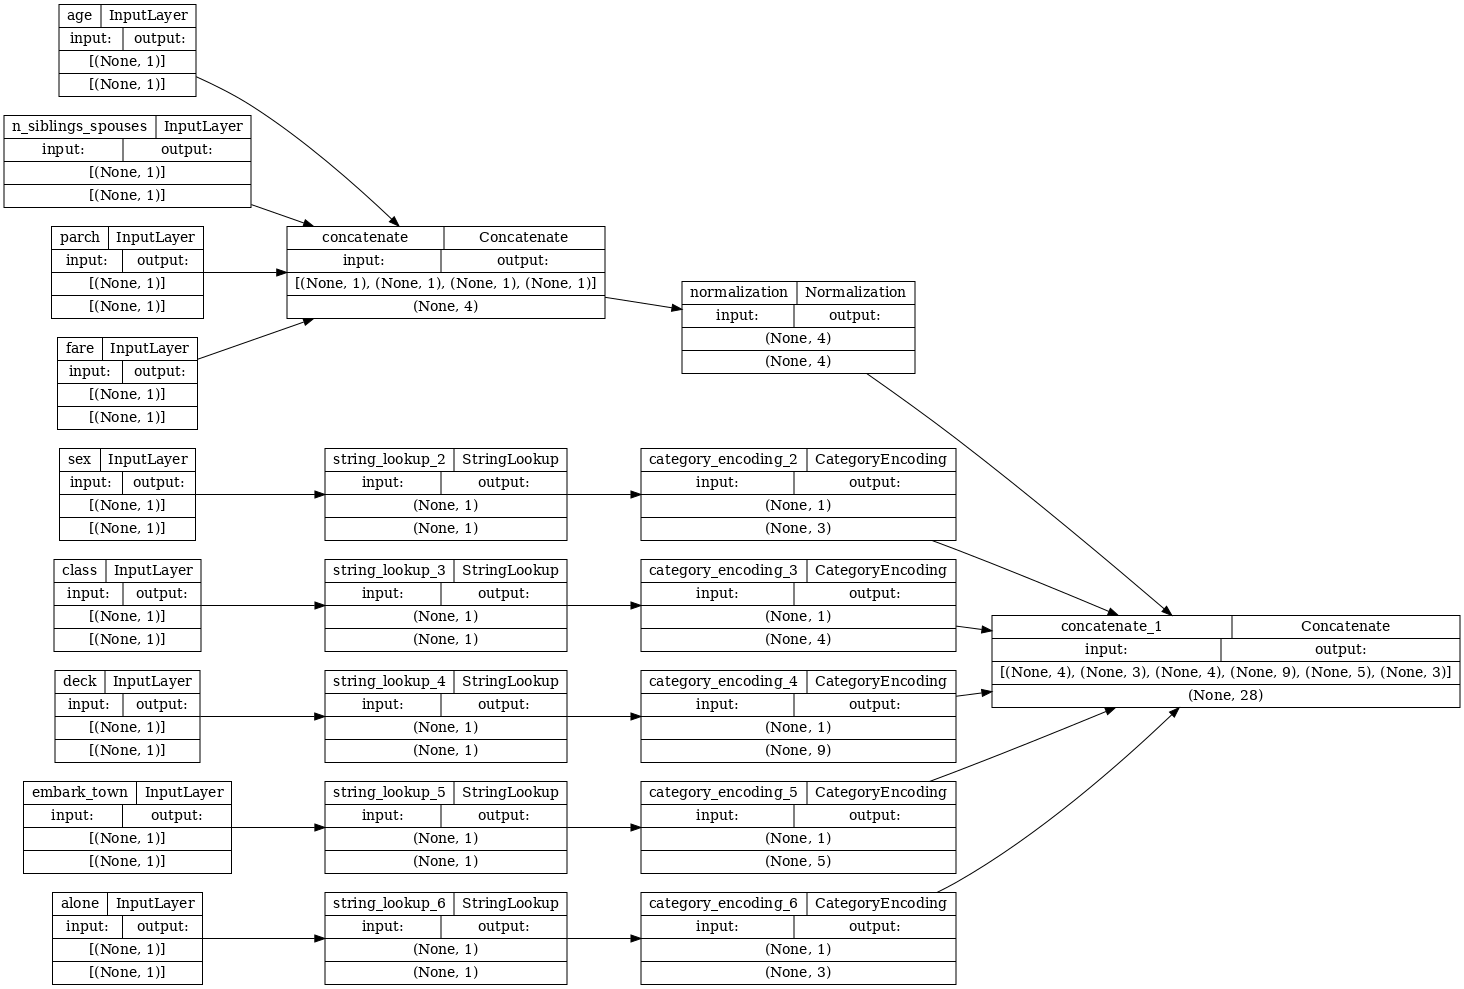

In [16]:
concatenate_layer = tf.keras.layers.Concatenate()

preprocessed_inputs_cat = concatenate_layer(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(
    model=titanic_preprocessing,
    rankdir="LR",
    dpi=72,
    show_shapes=True,
)

Preparación del archivo CSV
---

In [17]:
#
# Cada columna es un diccionario
#
titanic_features_dict = {
    name: np.array(value) for name, value in titanic_features.items()
}
#
# {
#     'sex': ['male', ...],
#     'age': array([22., ...],
#     'n_siblings_spouses': array([1, ...],
#     'parch': array([0, ...],
#     'fare': array([7.25, ...],
#     'class': array(['Third', ...],
#     'deck': array(['unknown', ...],
#     'embark_town': array(['Southampton', ...],
#     'alone': array(['n', ...]
# }
#


#
# Toma la primera fila de datos y aplica el preprocesador
#
features_dict = {name: values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[-0.610415 ,  0.395198 , -0.4790527, -0.4974028,  0.       ,
         0.       ,  1.       ,  0.       ,  0.       ,  0.       ,
         1.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  1.       ,
         0.       ,  0.       ,  0.       ,  1.       ,  0.       ,
         0.       ,  1.       ,  0.       ]], dtype=float32)>

Especificación y entrenamiento del modelo
---

In [18]:
def titanic_model(preprocessing_head, inputs):

    body = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(64),
            tf.keras.layers.Dense(1),
        ],
    )

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)

    model = tf.keras.Model(
        inputs,
        result,
    )

    model.compile(
        loss=tf.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.optimizers.Adam(),
    )
    return model


titanic_model = titanic_model(
    titanic_preprocessing,
    inputs,
)

history = titanic_model.fit(
    x=titanic_features_dict,
    y=titanic_labels,
    epochs=10,
)

Epoch 1/10
20/20 [==============================] - 1s 3ms/step - loss: 0.6721
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5422
Epoch 3/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5006
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 0.4728
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4538
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4409
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4332
Epoch 8/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4279
Epoch 9/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4255
Epoch 10/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4232
